# Linear Models for Semantic Similarity Predictions

Dataset: [Semantic Similarity Predictions for Phrases in U.S. Patents](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching)

This notebook contains first-cut analysis & linear similarity prediction models

### Approach
---

The goal of the dataset is to predict the semantic similarity score ($s \in [0.00, 0.25, 0.50, 0.75, 1.00]$) between an anchor phrase and a target phrase, with 0 being completely unrelated and 1 being closely related.

After performing exploratory data analysis, a few important observations can be made:

* Phrases themselves are relatively short (~2 words) with the majority of phrase pairs not sharing any words, thus, simple methods such as the distance between pairs of bag-of-words or TF-IDF vectors will not perform well.

* Similarity scores are on a scale of 0 to 1, but also grouped into 5 discrete buckets, thus, the problem can be cast as both a regression or multiclass classification problem.

This notebook will attempt to predict the similarity score using the following algorithms:

* Linear Regression, Logistic Regression

with the following feature engineering approaches:

* Levenshtein distance (e.g. edit distance) b/t anchor & target phrase as the feature

* Various permutations of pre-trained spaCy word vectors as the features (avg, multiply, cosine similarity, etc.)

* Various permutations of custom-trained word vectors as the features (Refer to: train-patents-embeddings.ipynb)

### Preprocessing
---

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from Levenshtein import distance as edit_dist

from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, LogisticRegressionCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
df_train_val = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_titles = pd.read_csv('./data/titles.csv')

df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=1)

#df_train['title'] = df_train['context'].map(lambda x: df_titles[df_titles.code == x]['title'])

In [17]:
lm = WordNetLemmatizer()
ps = PorterStemmer()

def lemmatize(text):
    return lm.lemmatize(text)

def stem(text):
    return ps.stem(text)

def remove_stopwords(tokens):
    tokens = [token.lower().strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    return filtered_tokens

def preprocess(sent, method='lem'):
    tokens = word_tokenize(sent)
    filtered_tokens = remove_stopwords(tokens)
    
    if method == 'lem':
        tokens = [lemmatize(token) for token in filtered_tokens]
    else:
        tokens = [stem(token) for token in filtered_tokens]

    return ' '.join(tokens)

In [18]:
%%time
df_train['preproc_anchor'] = df_train['anchor'].apply(lambda x: preprocess(x))
df_train['preproc_target'] = df_train['target'].apply(lambda x: preprocess(x))

df_val['preproc_anchor'] = df_val['anchor'].apply(lambda x: preprocess(x))
df_val['preproc_target'] = df_val['target'].apply(lambda x: preprocess(x))

CPU times: user 9.66 s, sys: 1.18 s, total: 10.8 s
Wall time: 10.9 s


### Levenshtein Distance
---

In [19]:
def calc_dist(df):
    return edit_dist(df.iloc[0], df.iloc[1])

In [71]:
df_train['edit_dist'] = df_train[['preproc_anchor', 'preproc_target']].apply(calc_dist, axis=1)
df_val['edit_dist'] = df_val[['preproc_anchor', 'preproc_target']].apply(calc_dist, axis=1)

In [72]:
X_train = df_train['edit_dist'].to_numpy().reshape(-1, 1)
X_val = df_val['edit_dist'].to_numpy().reshape(-1, 1)

y_train = df_train['score'].to_numpy().reshape(-1, 1)
y_val = df_val['score'].to_numpy().reshape(-1, 1)

In [73]:
le = LabelEncoder()
y_train_enc = le.fit_transform(df_train['score'])
y_val_enc = le.transform(df_val['score'])

In [74]:
y_train_bin = label_binarize(y_train_enc, classes=np.arange(0, 5))
y_val_bin = label_binarize(y_val_enc, classes=np.arange(0, 5))

#### Linear Regression

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print("R^2 Score: %.4f" % r2_score(y_val, y_pred))
print("RMSE: %.4f" % mean_squared_error(y_val, y_pred, squared=False))

R^2 Score: 0.0852
RMSE: 0.2502


In [24]:
rr = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0, 10.0])
rr.fit(X_train, y_train.ravel())

y_pred = rr.predict(X_val)

print("R^2 Score: %.4f" % r2_score(y_val, y_pred))
print("RMSE: %.4f" % mean_squared_error(y_val, y_pred, squared=False))

R^2 Score: 0.0852
RMSE: 0.2502


In [25]:
en = ElasticNetCV(cv=5, random_state=1, alphas=[0.001, 0.01, 0.1, 1.0, 10.0], l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9])
en.fit(X_train, y_train.ravel())

y_pred = en.predict(X_val)

print("R^2 Score: %.4f" % r2_score(y_val, y_pred))
print("RMSE: %.4f" % mean_squared_error(y_val, y_pred, squared=False))

R^2 Score: 0.0852
RMSE: 0.2502


#### Logistic Regression

In [70]:
def plot_roc_auc(y_true, y_pred, labels, model_name, file_path, figsize=(15, 10)):
    
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = 'Score = %.2f (AUC: %0.5f)'  % (lbl, areas[lbl]))

    ax.legend()
    ax.set_title('ROC Curves - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

def plot_precision_recall_auc(y_true, y_pred, labels, model_name, file_path, figsize=(15, 10)):

    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(rc, pr)
        ax.plot(rc, pr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))

    ax.legend()
    ax.set_title('Precision-Recall Curve - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');
    fig.savefig(file_path)
    plt.close(fig)

    return areas


def plot_auc(dict, title):
    plt.figure(figsize=(8, 5))
    fig = plt.bar([str(x) for x in dict.keys()], dict.values())
    plt.xlabel('Label')
    plt.ylabel('AUC')
    plt.title(title)
    plt.bar_label(fig, fmt='%.4f')


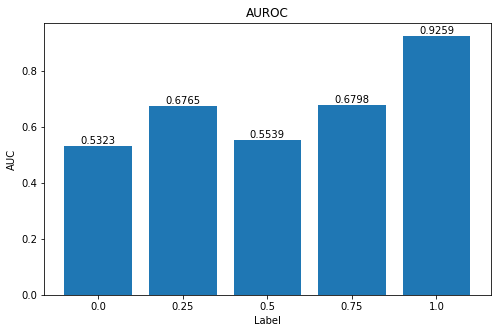

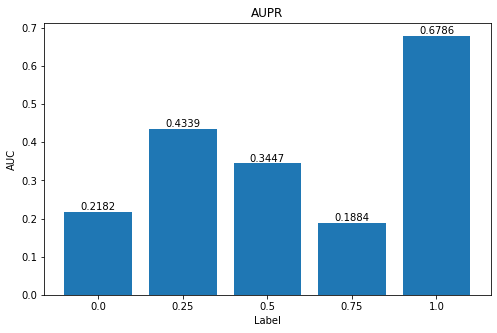

In [75]:
clf = OneVsRestClassifier(LogisticRegressionCV(cv=5, random_state=1, Cs=[0.001, 0.1, 1, 10, 100, 1000], max_iter=300))
clf.fit(X_train, y_train_bin)

y_pred = clf.predict_proba(X_val)

auroc = plot_roc_auc(y_val_bin, y_pred, np.linspace(0, 1, 5), 'edit_dist', r'./results/roc-edit-dist.jpg')
aupr = plot_precision_recall_auc(y_val_bin, y_pred, np.linspace(0, 1, 5), 'edit_dist', r'./results/pr-edit-dist.jpg')

plot_auc(auroc, 'AUROC')
plot_auc(aupr, 'AUPR')

### Pre-trained spaCy Model
---

Word embeddings (or word vectors) are learned, mathematical representations of words. With word embeddings, similar words have similar representations, thus, the idea explored in the following section is to use word embeddings to measure semantic similarity between the anchor and target phrase.

This is done through a few different methods:
* Multiplication - element-by-element, treat as feature vector

* Cosine Similarity & Euclidean Distance - use as measure of similarity (directly scale values to [0, 1] to use as y_pred)

The idea is illustrated in the diagram below.

<div>
<img src="./data/diagram.jpg" width="800"/>
</div>

In [46]:
nlp = spacy.load('en_core_web_lg')

In [76]:
%%time
X_train_mult = np.empty((0, 300), np.float32)
cos_sim = np.empty((0, 0), np.float32)
euc_dist = np.empty((0, 0), np.float32)

for ind, row in df_train.iterrows():
    anchor_phrase = row['preproc_anchor']
    target_phrase = row['preproc_target']

    anchor_vecs = np.array([nlp(word).vector for word in anchor_phrase.split(' ')])
    avg_anchor_vecs = np.average(anchor_vecs, axis=0).reshape(1, -1)

    target_vecs = np.array([nlp(word).vector for word in target_phrase.split(' ')])
    avg_target_vecs = np.average(target_vecs, axis=0).reshape(1, -1)

    feature_vec = np.multiply(avg_anchor_vecs, avg_target_vecs)

    X_train_mult = np.append(X_train_mult, feature_vec.reshape(1, 300), axis=0)
    cos_sim = np.append(cos_sim, cosine_similarity(avg_anchor_vecs, avg_target_vecs).flatten())
    euc_dist = np.append(euc_dist, np.sqrt(np.sum(np.square(avg_anchor_vecs - avg_target_vecs))))

CPU times: user 5min 22s, sys: 36.3 s, total: 5min 59s
Wall time: 5min 59s


In [77]:
%%time
X_val_mult = np.empty((0, 300), np.float32)
cos_sim_val = np.empty((0, 0), np.float32)
euc_dist_val = np.empty((0, 0), np.float32)

for ind, row in df_val.iterrows():
    anchor_phrase = row['preproc_anchor']
    target_phrase = row['preproc_target']

    anchor_vecs = np.array([nlp(word).vector for word in anchor_phrase.split(' ')])
    avg_anchor_vecs = np.average(anchor_vecs, axis=0).reshape(1, -1)

    target_vecs = np.array([nlp(word).vector for word in target_phrase.split(' ')])
    avg_target_vecs = np.average(target_vecs, axis=0).reshape(1, -1)

    feature_vec = np.multiply(avg_anchor_vecs, avg_target_vecs)

    X_val_mult = np.append(X_val_mult, feature_vec.reshape(1, 300), axis=0)
    cos_sim_val = np.append(cos_sim_val, cosine_similarity(avg_anchor_vecs, avg_target_vecs).flatten())
    euc_dist_val = np.append(euc_dist_val, np.sqrt(np.sum(np.square(avg_anchor_vecs - avg_target_vecs))))

CPU times: user 1min 13s, sys: 1.78 s, total: 1min 15s
Wall time: 1min 15s


#### Linear Regression

In [78]:
def fit_linear_models(X_train, y_train, X_val, y_val):
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    print('LINEAR REGRESSION:')
    print("R^2 Score: %.4f" % r2_score(y_val, y_pred))
    print("RMSE: %.4f" % mean_squared_error(y_val, y_pred, squared=False))
    print()

    # Ridge Regression
    rr = RidgeCV(cv=5, alphas=[0.001, 0.01, 0.1, 1.0, 10.0])
    rr.fit(X_train, y_train.ravel())

    y_pred = rr.predict(X_val)

    print('RIDGE REGRESSION:')
    print("R^2 Score: %.4f" % r2_score(y_val, y_pred))
    print("RMSE: %.4f" % mean_squared_error(y_val, y_pred, squared=False))
    print()

    # ElasticNet
    en = ElasticNetCV(cv=5, random_state=1, alphas=[0.001, 0.01, 0.1, 1.0, 10.0], l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9])
    en.fit(X_train, y_train.ravel())

    y_pred = en.predict(X_val)

    print('ELASTIC NET REGRESSION:')
    print("R^2 Score: %.4f" % r2_score(y_val, y_pred))
    print("RMSE: %.4f" % mean_squared_error(y_val, y_pred, squared=False))
    print()

In [79]:
fit_linear_models(X_train, y_train, X_val, y_val)

LINEAR REGRESSION:
R^2 Score: 0.0852
RMSE: 0.2502

RIDGE REGRESSION:
R^2 Score: 0.0852
RMSE: 0.2502

ELASTIC NET REGRESSION:
R^2 Score: 0.0852
RMSE: 0.2502



In [80]:
fit_linear_models(cos_sim.reshape(-1, 1), y_train, cos_sim_val.reshape(-1, 1), y_val)

LINEAR REGRESSION:
R^2 Score: 0.1795
RMSE: 0.2370

RIDGE REGRESSION:
R^2 Score: 0.1795
RMSE: 0.2370

ELASTIC NET REGRESSION:
R^2 Score: 0.1792
RMSE: 0.2370



In [81]:
fit_linear_models(euc_dist.reshape(-1, 1), y_train, euc_dist_val.reshape(-1, 1), y_val)

LINEAR REGRESSION:
R^2 Score: 0.2286
RMSE: 0.2298

RIDGE REGRESSION:
R^2 Score: 0.2286
RMSE: 0.2298

ELASTIC NET REGRESSION:
R^2 Score: 0.2285
RMSE: 0.2298



#### Logistic Regression

In [82]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_mult)
X_val_scaled = sc.transform(X_val_mult)

In [83]:
def fit_log_model(X_train, y_train, X_val, y_val, model_name, output_dir):

    clf = OneVsRestClassifier(LogisticRegressionCV(cv=5, random_state=1, Cs=[0.001, 0.1, 1, 10, 100, 1000], max_iter=300))
    clf.fit(X_train, y_train)

    y_pred = clf.predict_proba(X_val)

    auroc = plot_roc_auc(y_val, y_pred, np.linspace(0, 1, 5), model_name, output_dir + '/roc-' + model_name + '.jpg')
    aupr = plot_precision_recall_auc(y_val, y_pred, np.linspace(0, 1, 5), model_name, output_dir + '/pr-' + model_name + '.jpg')

    plot_auc(auroc, 'AUROC')
    plot_auc(aupr, 'AUPR')

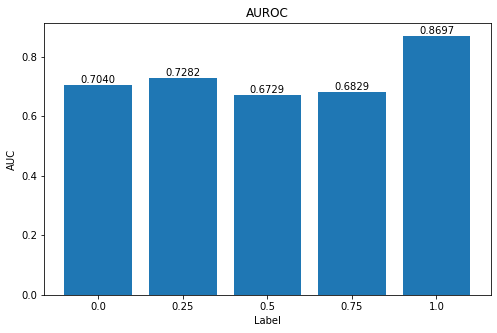

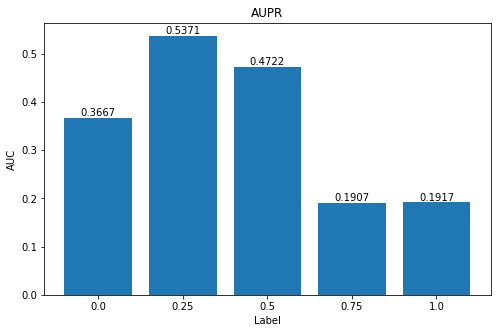

In [84]:
# X_train_scaled used for numerical stability, X_train has trouble converging
fit_log_model(X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, 'mult', r'./results')

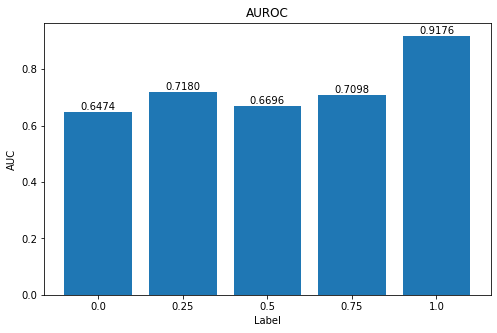

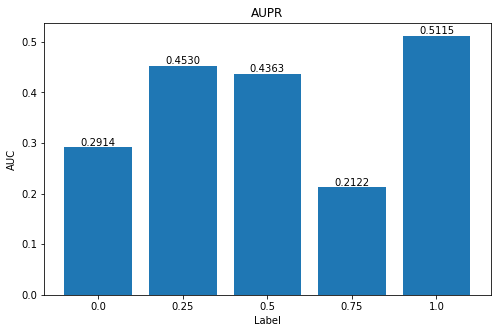

In [86]:
fit_log_model(cos_sim.reshape(-1, 1), y_train_bin, cos_sim_val.reshape(-1, 1), y_val_bin, 'cos-sim', r'./results')

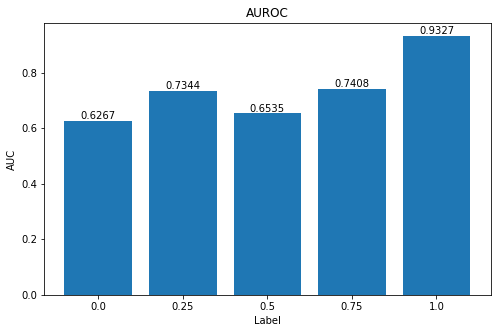

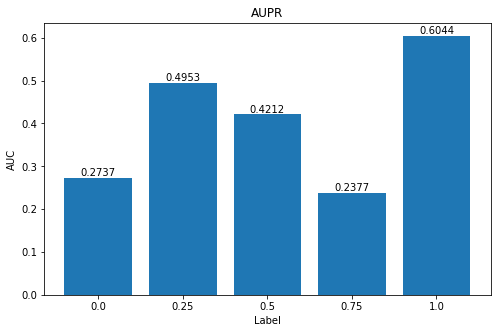

In [87]:
fit_log_model(euc_dist.reshape(-1, 1), y_train_bin, euc_dist_val.reshape(-1, 1), y_val_bin, 'euc-dist', r'./results')

### Custom Trained Word Vectors (gensim)
---

#### Linear Regression

#### Logistic Regression

### Conclusions
---

* Posing the 